In [1]:
!pip install -U sentence-transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [6]:
pd.options.display.max_columns = None

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Load transactions

In [8]:
train_set_orig = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(train_set_orig.shape)
train_set_orig.head()

(588758, 3)


,t_dat,customer_id,article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002


In [9]:
test_set = pd.read_csv('data/splits/test_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(test_set.shape)
test_set.head()

(32995, 3)


,t_dat,customer_id,article_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001


Only include articles bought after 2020-01

In [10]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [11]:
article_id_to_keep = train_set_orig[train_set_orig['t_dat'] > '2020-08-01']['article_id'].unique()
len(article_id_to_keep)

11270

In [12]:
print(train_set_orig.shape)
train_set_orig = train_set_orig.copy()[train_set_orig['article_id'].isin(article_id_to_keep)]
print(train_set_orig.shape)

(588758, 3)
(202947, 3)


### Load customer features

In [13]:
customers = pd.read_csv('data/customers.csv')
print(customers.shape)
customers.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [14]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [15]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

In [16]:
customers['club_member_status'] = customers['club_member_status'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [17]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [18]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('none', 'missing')

In [19]:
customers.isnull().sum()

customer_id                   0
FN                            0
Active                        0
club_member_status            0
fashion_news_frequency        0
age                       15861
postal_code                   0
dtype: int64

`customer_id` to indices

In [20]:
unique_customers_df = test_set[['customer_id']].drop_duplicates().reset_index(drop=True)

customer_id_to_idx = dict(
    zip(
        unique_customers_df['customer_id'],
        unique_customers_df.index
    )
)

len(customer_id_to_idx)

9208

In [21]:
customers_cat_code_to_indices = {}

for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers_cat_code_to_indices[cat] = {v: k for k, v in dict(enumerate(customers[cat].unique())).items()}

In [22]:
for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers[cat] = customers[cat].map(customers_cat_code_to_indices[cat])

In [23]:
customers['customer_id_idx'] = customers['customer_id'].map(customer_id_to_idx)

In [24]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,0,0,49.0,0,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,0,0,25.0,1,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,0,0,24.0,2,0.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,0,0,54.0,3,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,0,1,52.0,4,NaN


In [25]:
train_set_orig['customer_id_idx'] = train_set_orig['customer_id'].map(customer_id_to_idx)

### Train-dev split

In [26]:
end = train_set_orig['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)

endm1, end

(Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [27]:
train_set = train_set_orig.copy()[train_set_orig['t_dat'] < endm1]

dev_set = train_set_orig.copy()[train_set_orig['t_dat'] >= endm1]

train_set.drop(columns=['t_dat'], inplace=True)
dev_set.drop(columns=['t_dat'], inplace=True)

train_set.shape, dev_set.shape

((194584, 3), (8363, 3))

### Generate negative samples

In [28]:
train_set.head()

,customer_id,article_id,customer_id_idx
17,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,3631
43,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001,1120
55,183c939bc508ee9c530be249a4e940aace700cdc774e2c...,0615141002,8343
72,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245046,2259
77,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245001,2259


In [29]:
top_1000 = train_set['article_id'].value_counts().head(1000).index.tolist()
top_1000[:5]

['0706016001', '0706016002', '0372860001', '0610776002', '0759871002']

In [30]:
# print(train_set.shape)
# train_set = train_set.copy()[train_set['article_id'].isin(top_1000)]
# print(train_set.shape)

In [31]:
# print(dev_set.shape)
# dev_set = dev_set.copy()[dev_set['article_id'].isin(top_1000)]
# print(dev_set.shape)

In [32]:
train_set_by_customer = train_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(train_set_by_customer.shape)
train_set_by_customer.head()

(8778, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0723529001, 0351484002, 0351484002, 0851400006]"
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0714029002, 0591334019, 0685813001, 075147100..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0570002001, 0770816001, 0501620042, 082217100..."
3,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100..."
4,004d932f7a27ac3167c77db81d9cfd89392729e7f7e0d4...,"[0679854005, 0679854005, 0679854005, 057371601..."


In [33]:
train_set_by_customer['negative_samples'] = train_set_by_customer.apply(lambda x: list(set(top_1000) - set(x['article_id'])), axis=1)

In [34]:
train_set_by_customer['num_negative_samples'] = train_set_by_customer['negative_samples'].apply(len)

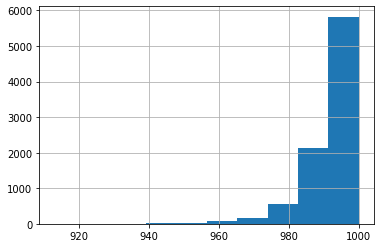

In [35]:
train_set_by_customer['num_negative_samples'].hist()

In [36]:
# (train_set_by_customer['num_negative_samples'] == 1000).mean()

Drop customers with 1000 negative examples, which means they had no positive examples in this set

In [37]:
# train_set_by_customer = train_set_by_customer.copy()[train_set_by_customer['num_negative_samples'] != 1000]

In [38]:
train_set_by_customer.head()

,customer_id,article_id,negative_samples,num_negative_samples
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0723529001, 0351484002, 0351484002, 0851400006]","[0600886001, 0844409002, 0678942032, 087097000...",998
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0714029002, 0591334019, 0685813001, 075147100...","[0600886001, 0844409002, 0678942032, 087097000...",989
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0570002001, 0770816001, 0501620042, 082217100...","[0600886001, 0844409002, 0678942032, 087097000...",999
3,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100...","[0600886001, 0844409002, 0678942032, 087097000...",990
4,004d932f7a27ac3167c77db81d9cfd89392729e7f7e0d4...,"[0679854005, 0679854005, 0679854005, 057371601...","[0600886001, 0844409002, 0678942032, 087097000...",988


In [39]:
negative_samples_df = train_set_by_customer[['customer_id', 'negative_samples']].explode('negative_samples')
negative_samples_df['purchased'] = 0
negative_samples_df.rename(columns={'negative_samples': 'article_id'}, inplace=True)
print(negative_samples_df.shape)
negative_samples_df.head()

(8710061, 3)


,customer_id,article_id,purchased
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0600886001,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0844409002,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0678942032,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0870970001,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0825577001,0


In [40]:
positive_samples = train_set.copy()
positive_samples['purchased'] = 1
print(positive_samples.shape)
positive_samples.head()

(194584, 4)


,customer_id,article_id,customer_id_idx,purchased
17,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,3631,1
43,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001,1120,1
55,183c939bc508ee9c530be249a4e940aace700cdc774e2c...,0615141002,8343,1
72,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245046,2259,1
77,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245001,2259,1


In [41]:
train_set = pd.concat([
    positive_samples,
    negative_samples_df
])

train_set = train_set.sample(frac=1, random_state=3)  # shuffle
print(train_set.shape)
train_set.head()

(8904645, 4)


,customer_id,article_id,customer_id_idx,purchased
5015,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0803757004,NaN,0
6805,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,0816563004,NaN,0
4477,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0452818001,NaN,0
6345,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,0698276009,NaN,0
7911,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0824997001,NaN,0


In [42]:
train_set['purchased'].mean()

0.021851966024473743

In [43]:
# Check at least 1 positive label per customer
train_set.groupby('customer_id')['purchased'].sum().min() >= 1

True

Dev set prep

In [44]:
dev_set.head()

,customer_id,article_id,customer_id_idx
580395,00639e775b90554156986100685c4d408723c77e411e37...,0891591007,1072
580396,00639e775b90554156986100685c4d408723c77e411e37...,0891591001,1072
580397,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0909924004,8244
580398,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0921266005,8244
580399,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0857163001,8244


In [45]:
# # For purposes of dev set only include transactions in top-1000
# dev_set['article_id'].isin(top_1000).mean()

In [46]:
# positive_samples_dev = dev_set.copy()[dev_set['article_id'].isin(top_1000)]
positive_samples_dev = dev_set.copy()
positive_samples_dev['purchased'] = 1
print(positive_samples_dev.shape)
positive_samples_dev.head()

(8363, 4)


,customer_id,article_id,customer_id_idx,purchased
580395,00639e775b90554156986100685c4d408723c77e411e37...,0891591007,1072,1
580396,00639e775b90554156986100685c4d408723c77e411e37...,0891591001,1072,1
580397,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0909924004,8244,1
580398,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0921266005,8244,1
580399,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0857163001,8244,1


In [47]:
positive_samples_dev_by_customer = positive_samples_dev.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(positive_samples_dev_by_customer.shape)
positive_samples_dev_by_customer.head()

(1998, 2)


,customer_id,article_id
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,[0903924001]
1,0054c50274d19af58d53ef3ce0c004bea446c80bd51cf2...,"[0766346011, 0568601043, 0763037001]"
2,00639e775b90554156986100685c4d408723c77e411e37...,"[0891591007, 0891591001, 0891591001]"
3,00798bd464457d23d6af401715fe32d5c676ad9ee4010d...,[0916775002]
4,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0867969003, 0867969003, 0448509014, 088290001..."


In [48]:
positive_samples_dev_by_customer['negative_samples'] = positive_samples_dev_by_customer.apply(lambda x: list(set(top_1000) - set(x['article_id'])), axis=1)

In [49]:
negative_samples_df = positive_samples_dev_by_customer[['customer_id', 'negative_samples']].explode('negative_samples')
negative_samples_df['purchased'] = 0
negative_samples_df.rename(columns={'negative_samples': 'article_id'}, inplace=True)
print(negative_samples_df.shape)
negative_samples_df.head()

(1996939, 3)


,customer_id,article_id,purchased
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0600886001,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0844409002,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0678942032,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0870970001,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0825577001,0


In [50]:
dev_set = pd.concat([
    positive_samples_dev,
    negative_samples_df
])

dev_set = dev_set.sample(frac=1, random_state=3)  # shuffle
print(dev_set.shape)
dev_set.head()

(2005302, 4)


,customer_id,article_id,customer_id_idx,purchased
1922,f7cff47ca5eed528a9990e21e619878b002d7ce393f471...,0859105003,NaN,0
1247,9d4f9874a43da353c42bfdf70368ac6ef7c080613a0ab0...,0559616013,NaN,0
73,0b50b5aeb1d21ccf35ab72b056b041950806e6474d2be6...,0803250001,NaN,0
1502,c037b35b7422f7c90b50c85f76fe0c35af5b633f90b63d...,0866383001,NaN,0
135,136b571bf08e948b9fc5ef62c1e300a9a2f00e2bbddd9f...,0783244002,NaN,0


In [51]:
dev_set['purchased'].mean()

0.004170444152551586

`article_id` to indices

In [52]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str},
    usecols=['article_id', 'garment_group_name', 'detail_desc']
)
print(articles_df.shape)
articles_df.head()

(105542, 3)


,article_id,garment_group_name,detail_desc
0,0108775015,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [53]:
# articles_df = articles_df.copy()[articles_df['article_id'].isin(top_1000)]

In [54]:
articles_df.reset_index(drop=True, inplace=True)

In [55]:
print(articles_df.shape)
articles_df.head()

(105542, 3)


,article_id,garment_group_name,detail_desc
0,0108775015,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [56]:
articles_df['article_id_idx'] = articles_df.index

In [57]:
articles_df.isnull().sum()

article_id              0
garment_group_name      0
detail_desc           416
article_id_idx          0
dtype: int64

In [58]:
articles_df['detail_desc'] = np.where(
    articles_df['detail_desc'].isnull(), 
    articles_df['garment_group_name'],
    articles_df['detail_desc']
)

In [59]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [60]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [61]:
embeddings = model.encode(article_descriptions)

In [62]:
embeddings = torch.tensor(embeddings)

In [63]:
embeddings.shape

torch.Size([105542, 384])

In [64]:
article_id_to_idx = dict(
    zip(
        articles_df['article_id'], 
        articles_df['article_id_idx']
    )
)

In [65]:
train_set['article_id_idx'] = train_set['article_id'].map(article_id_to_idx)
dev_set['article_id_idx'] = dev_set['article_id'].map(article_id_to_idx)

In [66]:
train_set.head()

,customer_id,article_id,customer_id_idx,purchased,article_id_idx
5015,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0803757004,NaN,0,80922
6805,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,0816563004,NaN,0,84641
4477,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0452818001,NaN,0,3280
6345,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,0698276009,NaN,0,51120
7911,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0824997001,NaN,0,86781


In [67]:
dev_set.head()

,customer_id,article_id,customer_id_idx,purchased,article_id_idx
1922,f7cff47ca5eed528a9990e21e619878b002d7ce393f471...,0859105003,NaN,0,93629
1247,9d4f9874a43da353c42bfdf70368ac6ef7c080613a0ab0...,0559616013,NaN,0,13713
73,0b50b5aeb1d21ccf35ab72b056b041950806e6474d2be6...,0803250001,NaN,0,80755
1502,c037b35b7422f7c90b50c85f76fe0c35af5b633f90b63d...,0866383001,NaN,0,95395
135,136b571bf08e948b9fc5ef62c1e300a9a2f00e2bbddd9f...,0783244002,NaN,0,75874


In [68]:
train_set['customer_id_idx'] = train_set['customer_id'].map(customer_id_to_idx)
dev_set['customer_id_idx'] = dev_set['customer_id'].map(customer_id_to_idx)

In [69]:
train_set['customer_id_idx'].isnull().sum() + dev_set['customer_id_idx'].isnull().sum()

0

In [70]:
train_set['article_id_idx'].isnull().sum() + dev_set['article_id_idx'].isnull().sum()

0

### Merge features

In [71]:
train_set.head()

,customer_id,article_id,customer_id_idx,purchased,article_id_idx
5015,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0803757004,8789,0,80922
6805,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,0816563004,1892,0,84641
4477,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0452818001,6818,0,3280
6345,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,0698276009,5935,0,51120
7911,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0824997001,6136,0,86781


In [72]:
train_set = (
    train_set[['purchased', 'customer_id_idx', 'article_id_idx']]
    .merge(customers, on='customer_id_idx', how='left')
    # .merge(articles_df, on='article_id_idx', how='left')
)
print(train_set.shape)
train_set.head()

(8904645, 10)


,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,8789,80922,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0.0,0.0,0,0,30.0,293202
1,0,1892,84641,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,1.0,1.0,0,1,21.0,83211
2,0,6818,3280,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0.0,0.0,0,0,23.0,17012
3,0,5935,51120,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,1.0,1.0,0,1,49.0,319383
4,0,6136,86781,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0.0,0.0,0,0,20.0,28596


In [73]:
dev_set = (
    dev_set[['purchased', 'customer_id_idx', 'article_id_idx']]
    .merge(customers, on='customer_id_idx', how='left')
    # .merge(articles_df, on='article_id_idx', how='left')
)
print(dev_set.shape)
dev_set.head()

(2005302, 10)


,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,4933,93629,f7cff47ca5eed528a9990e21e619878b002d7ce393f471...,0.0,0.0,0,0,24.0,272622
1,0,660,13713,9d4f9874a43da353c42bfdf70368ac6ef7c080613a0ab0...,0.0,0.0,0,0,43.0,233912
2,0,5034,80755,0b50b5aeb1d21ccf35ab72b056b041950806e6474d2be6...,1.0,1.0,0,1,20.0,49473
3,0,7060,95395,c037b35b7422f7c90b50c85f76fe0c35af5b633f90b63d...,1.0,1.0,0,1,53.0,17595
4,0,80,75874,136b571bf08e948b9fc5ef62c1e300a9a2f00e2bbddd9f...,0.0,0.0,0,0,20.0,32754


### Impute `NULL`s

In [74]:
train_set.isnull().sum()[train_set.isnull().sum() > 0]

age    32229
dtype: int64

In [75]:
dev_set.isnull().sum()[dev_set.isnull().sum() > 0]

age    7020
dtype: int64

In [76]:
from sklearn.impute import SimpleImputer

In [77]:
age_imputer = SimpleImputer()

In [78]:
age_imputer.fit(train_set['age'].values.reshape(-1, 1))

SimpleImputer()

In [79]:
train_set['age'] = age_imputer.transform(train_set['age'].values.reshape(-1, 1))

In [80]:
dev_set['age'] = age_imputer.transform(dev_set['age'].values.reshape(-1, 1))

In [81]:
train_set.head()

,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,8789,80922,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0.0,0.0,0,0,30.0,293202
1,0,1892,84641,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,1.0,1.0,0,1,21.0,83211
2,0,6818,3280,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0.0,0.0,0,0,23.0,17012
3,0,5935,51120,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,1.0,1.0,0,1,49.0,319383
4,0,6136,86781,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0.0,0.0,0,0,20.0,28596


### Train model

In [82]:
NUMERIC_FEATURES = [
    'FN', 
    'Active', 
    'age'
]

In [83]:
# train_set[[
#     'customer_id_idx',
#     'article_id_idx',
#     'product_code',
#     'product_type_no',
#     'graphical_appearance_no',
#     'perceived_colour_value_id',
#     'perceived_colour_master_id',
#     'department_no',
#     'index_code',
#     'index_group_no',
#     'section_no',
#     'garment_group_no',
#     'club_member_status',
#     'fashion_news_frequency',
#     'postal_code',
#     'purchased'] +
#     NUMERIC_FEATURES
# ]

In [84]:
train_set.head()

,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,8789,80922,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0.0,0.0,0,0,30.0,293202
1,0,1892,84641,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,1.0,1.0,0,1,21.0,83211
2,0,6818,3280,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0.0,0.0,0,0,23.0,17012
3,0,5935,51120,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,1.0,1.0,0,1,49.0,319383
4,0,6136,86781,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0.0,0.0,0,0,20.0,28596


In [85]:
class PurchasesDatasetWithArticleFeatures(Dataset):

    def __init__(self, df):
        self.customer_id_idx = df['customer_id_idx'].values
        self.article_id_idx = df['article_id_idx'].values
        # self.product_code = df['product_code'].values
        # self.product_type_no = df['product_type_no'].values
        # self.product_group_no = df['product_group_no'].values
        # self.graphical_appearance_no = df['graphical_appearance_no'].values
        # self.colour_group_code = df['colour_group_code'].values
        # self.perceived_colour_value_id = df['perceived_colour_value_id'].values
        # self.perceived_colour_master_id = df['perceived_colour_master_id'].values
        # self.department_no = df['department_no'].values
        # self.index_code = df['index_code'].values
        # self.index_group_no = df['index_group_no'].values
        # self.section_no = df['section_no'].values
        # self.garment_group_no = df['garment_group_no'].values
        
        # self.club_member_status = df['club_member_status'].values
        # self.fashion_news_frequency = df['fashion_news_frequency'].values
        # self.postal_code = df['postal_code'].values
        self.numeric_features = df[NUMERIC_FEATURES].values
        
        self.purchased = df['purchased'].values

    def __len__(self):
        return self.customer_id_idx.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            self.customer_id_idx[idx],
            self.article_id_idx[idx],
            # self.product_code[idx],
            # self.product_type_no[idx],
            # self.product_group_no[idx],
            # self.graphical_appearance_no[idx],
            # self.colour_group_code[idx],
            # self.perceived_colour_value_id[idx],
            # self.perceived_colour_master_id[idx],
            # self.department_no[idx],
            # self.index_code[idx],
            # self.index_group_no[idx],
            # self.section_no[idx],
            # self.garment_group_no[idx],
            # self.club_member_status[idx],
            # self.fashion_news_frequency[idx],
            # self.postal_code[idx],
            self.numeric_features[idx],
            self.purchased[idx]
        )

In [86]:
train_dataset = PurchasesDatasetWithArticleFeatures(train_set)
dev_dataset = PurchasesDatasetWithArticleFeatures(dev_set)

In [87]:
BATCH_SIZE = 2048

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)  

In [88]:
# # Selecting a subset of data
# subset = torch.utils.data.Subset(train_dataset, [1])

# train_loader = DataLoader(subset, batch_size=BATCH_SIZE)  

In [133]:
class FashionRecV2(nn.Module):

    def __init__(self, embedding_dim):
        super(FashionRecV2, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customer_id_to_idx), embedding_dim=embedding_dim)        
        # self.item_embeddings = nn.Embedding(num_embeddings=len(article_id_to_idx), embedding_dim=embedding_dim)
        self.item_embeddings = nn.Embedding.from_pretrained(embeddings, freeze=True)
        # self.product_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_code']), embedding_dim=embedding_dim)
        # self.product_type_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_type_no']), embedding_dim=embedding_dim)
        # self.product_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_group_no']), embedding_dim=embedding_dim)
        # self.graphical_appearance_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['graphical_appearance_no']), embedding_dim=embedding_dim)
        # self.colour_group_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['colour_group_code']), embedding_dim=embedding_dim)
        # self.perceived_colour_value_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_value_id']), embedding_dim=embedding_dim)
        # self.perceived_colour_master_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_master_id']), embedding_dim=embedding_dim)
        # self.department_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['department_no']), embedding_dim=embedding_dim)
        # self.index_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_code']), embedding_dim=embedding_dim)
        # self.index_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_group_no']), embedding_dim=embedding_dim)
        # self.section_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['section_no']), embedding_dim=embedding_dim)
        # self.garment_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['garment_group_no']), embedding_dim=embedding_dim)
        
        # self.club_member_status_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['club_member_status']), embedding_dim=embedding_dim)
        # self.fashion_news_frequency_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['fashion_news_frequency']), embedding_dim=embedding_dim)
        # self.postal_code_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['postal_code']), embedding_dim=embedding_dim)

        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.item_embeddings.weight)        
        # torch.nn.init.xavier_uniform_(self.product_code_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.product_type_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.product_group_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.graphical_appearance_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.colour_group_code_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.perceived_colour_value_id_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.perceived_colour_master_id_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.department_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.index_code_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.index_group_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.section_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.garment_group_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.club_member_status_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.fashion_news_frequency_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.postal_code_embeddings.weight)
        
        # FC layers
        # self.fc_1 = nn.Linear(in_features=embedding_dim*17+len(NUMERIC_FEATURES), out_features=128)            
        self.fc_1 = nn.Linear(in_features=embedding_dim + 384 +len(NUMERIC_FEATURES), out_features=128)            
        # self.fc_2 = nn.Linear(in_features=256, out_features=256)
        # self.fc_3 = nn.Linear(in_features=500, out_features=250)        
        self.fc_2 = nn.Linear(in_features=128, out_features=1)
        
        # Activation functions
        self.relu = nn.ReLU()        
        self.sigmoid = nn.Sigmoid()
        
        # Dropout
        self.dropout = nn.Dropout(0.15)
        
    def forward(
        self, 
        user_id, 
        item_id,
        # product_code, 
        # product_type_no, 
        # product_group_no, 
        # graphical_appearance_no, 
        # colour_group_code, 
        # perceived_colour_value_id, 
        # perceived_colour_master_id, 
        # department_no, 
        # index_code, 
        # index_group_no, 
        # section_no, 
        # garment_group_no,
        # club_member_status,
        # fashion_news_frequency,
        # postal_code,
        numeric_features,
    ):

        user_emb = self.user_embeddings(user_id)
        item_emb = self.item_embeddings(item_id)
        # product_code_emb = self.product_code_embeddings(product_code)
        # product_type_no_emb = self.product_type_no_embeddings(product_type_no)
        # product_group_no_emb = self.product_group_no_embeddings(product_group_no)
        # graphical_appearance_no_emb = self.graphical_appearance_no_embeddings(graphical_appearance_no)
        # colour_group_code_emb = self.colour_group_code_embeddings(colour_group_code)
        # perceived_colour_value_id_emb = self.perceived_colour_value_id_embeddings(perceived_colour_value_id)
        # perceived_colour_master_id_emb = self.perceived_colour_master_id_embeddings(perceived_colour_master_id)
        # department_no_emb = self.department_no_embeddings(department_no)
        # index_code_emb = self.index_code_embeddings(index_code)
        # index_group_no_emb = self.index_group_no_embeddings(index_group_no)
        # section_no_emb = self.section_no_embeddings(section_no)
        # garment_group_no_emb = self.garment_group_no_embeddings(garment_group_no)
        
        # club_member_status_emb = self.club_member_status_embeddings(club_member_status)
        # fashion_news_frequency_emb = self.fashion_news_frequency_embeddings(fashion_news_frequency)
        # postal_code_emb = self.postal_code_embeddings(postal_code)
              
        concatenated_emb = torch.concat(
            [
                user_emb, 
                item_emb,
                # product_code_emb,
                # product_type_no_emb,
                # product_group_no_emb,
                # graphical_appearance_no_emb,
                # colour_group_code_emb,
                # perceived_colour_value_id_emb,
                # perceived_colour_master_id_emb,
                # department_no_emb,
                # index_code_emb,
                # index_group_no_emb,
                # section_no_emb,
                # garment_group_no_emb,
                # club_member_status_emb,
                # fashion_news_frequency_emb,
                # postal_code_emb,
                numeric_features
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_emb)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_3(x)
        x = self.sigmoid(x)

        return x

In [134]:
fashion_rec_v2 = FashionRecV2(embedding_dim=128)

In [135]:
fashion_rec_v2.to(device)

FashionRecV2(
  (user_embeddings): Embedding(9208, 128)
  (item_embeddings): Embedding(105542, 384)
  (fc_1): Linear(in_features=515, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.15, inplace=False)
)

In [136]:
# fashion_rec_v2(torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), )

In [137]:
# optimizer = torch.optim.Adam(params=fashion_rec_v2.parameters(), lr=0.001)
optimizer = torch.optim.Adam(params=fashion_rec_v2.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Switched to BCELoss instead of weighted MSE. Had more success with this.

In [138]:
criterion = nn.BCELoss()

In [139]:
# MAX_EPOCHS = 5
# training_losses = []
# dev_losses = []

# for epoch in range(MAX_EPOCHS):
    
#     for data in tqdm(train_loader):
        
#         user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data    
        
#         user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
#             user_id.to(device), 
#             item_id.to(device), 
#             product_code.to(device), 
#             product_type_no.to(device), 
#             product_group_no.to(device), 
#             graphical_appearance_no.to(device), 
#             colour_group_code.to(device), 
#             perceived_colour_value_id.to(device), 
#             perceived_colour_master_id.to(device), 
#             department_no.to(device), 
#             index_code.to(device), 
#             index_group_no.to(device), 
#             section_no.to(device), 
#             garment_group_no.to(device), 
#             club_member_status.to(device), 
#             fashion_news_frequency.to(device), 
#             postal_code.to(device), 
#             numeric_features.to(device),
#             label.to(device)
#         )    

#         optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

#         pred = fashion_rec_v2(
#             user_id, 
#             item_id, 
#             product_code, 
#             product_type_no, 
#             product_group_no, 
#             graphical_appearance_no, 
#             colour_group_code, 
#             perceived_colour_value_id, 
#             perceived_colour_master_id, 
#             department_no, 
#             index_code, 
#             index_group_no, 
#             section_no, 
#             garment_group_no,
#             club_member_status,
#             fashion_news_frequency,
#             postal_code,
#             numeric_features.float()
#         )

#         loss = criterion(pred.flatten(), label.float())

#         loss.backward()  
        
#         optimizer.step()
        
#     # Compute training loss
    
#     total_train_loss = 0

#     fashion_rec_v2.eval()

#     with torch.no_grad():
#         for data in tqdm(DataLoader(train_dataset, batch_size=BATCH_SIZE*4)):
            
#             user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data

#             user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
#                 user_id.to(device), 
#                 item_id.to(device), 
#                 product_code.to(device), 
#                 product_type_no.to(device), 
#                 product_group_no.to(device), 
#                 graphical_appearance_no.to(device), 
#                 colour_group_code.to(device), 
#                 perceived_colour_value_id.to(device), 
#                 perceived_colour_master_id.to(device), 
#                 department_no.to(device), 
#                 index_code.to(device), 
#                 index_group_no.to(device), 
#                 section_no.to(device), 
#                 garment_group_no.to(device), 
#                 club_member_status.to(device), 
#                 fashion_news_frequency.to(device), 
#                 postal_code.to(device), 
#                 numeric_features.to(device),
#                 label.to(device)
#             )

#             pred = fashion_rec_v2(
#                 user_id, 
#                 item_id, 
#                 product_code, 
#                 product_type_no, 
#                 product_group_no, 
#                 graphical_appearance_no, 
#                 colour_group_code, 
#                 perceived_colour_value_id, 
#                 perceived_colour_master_id, 
#                 department_no, 
#                 index_code, 
#                 index_group_no, 
#                 section_no, 
#                 garment_group_no,
#                 club_member_status,
#                 fashion_news_frequency,
#                 postal_code,
#                 numeric_features.float()
#             )

#             loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

#             total_train_loss += loss.item()

#         mean_train_loss = total_train_loss / len(train_dataset)

#         print(f"Training loss: {mean_train_loss}")
#         training_losses.append(mean_train_loss)
    
#     # Compute dev loss
    
#     total_dev_loss = 0

#     with torch.no_grad():
#         for data in tqdm(DataLoader(dev_dataset, batch_size=BATCH_SIZE*4)):
            
#             user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data                    
        
#             user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
#                 user_id.to(device), 
#                 item_id.to(device), 
#                 product_code.to(device), 
#                 product_type_no.to(device), 
#                 product_group_no.to(device), 
#                 graphical_appearance_no.to(device), 
#                 colour_group_code.to(device), 
#                 perceived_colour_value_id.to(device), 
#                 perceived_colour_master_id.to(device), 
#                 department_no.to(device), 
#                 index_code.to(device), 
#                 index_group_no.to(device), 
#                 section_no.to(device), 
#                 garment_group_no.to(device), 
#                 club_member_status.to(device), 
#                 fashion_news_frequency.to(device), 
#                 postal_code.to(device), 
#                 numeric_features.to(device),
#                 label.to(device)
#             )    

#             optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

#             pred = fashion_rec_v2(
#                 user_id, 
#                 item_id, 
#                 product_code, 
#                 product_type_no, 
#                 product_group_no, 
#                 graphical_appearance_no, 
#                 colour_group_code, 
#                 perceived_colour_value_id, 
#                 perceived_colour_master_id, 
#                 department_no, 
#                 index_code, 
#                 index_group_no, 
#                 section_no, 
#                 garment_group_no,
#                 club_member_status,
#                 fashion_news_frequency,
#                 postal_code,
#                 numeric_features.float()
#             )

#             loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

#             total_dev_loss += loss.item()

#         mean_dev_loss = total_dev_loss / len(dev_dataset)

#         print(f"Dev loss: {mean_dev_loss}")
#         dev_losses.append(mean_dev_loss)
    
#     fashion_rec_v2.train()

In [140]:
MAX_EPOCHS = 30
training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    for data in tqdm(train_loader):
        
        user_id, item_id, numeric_features, label = data    
        
        user_id, item_id, numeric_features, label = (
            user_id.to(device), 
            item_id.to(device), 
            numeric_features.to(device),
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            numeric_features.float()
        )

        loss = criterion(pred.flatten(), label.float())

        loss.backward()  
        
        optimizer.step()

    scheduler.step()
        
    # Compute training loss
    
    total_train_loss = 0

    fashion_rec_v2.eval()

    with torch.no_grad():
        for data in tqdm(DataLoader(train_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, numeric_features, label = data

            user_id, item_id, numeric_features, label = (
                user_id.to(device), 
                item_id.to(device), 
                numeric_features.to(device),
                label.to(device)
            )

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                numeric_features.float()
            )

            loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / len(train_dataset)

        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
    
    # Compute dev loss
    
    total_dev_loss = 0

    with torch.no_grad():
        for data in tqdm(DataLoader(dev_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, numeric_features, label = data                    
        
            user_id, item_id, numeric_features, label = (
                user_id.to(device), 
                item_id.to(device), 
                numeric_features.to(device),
                label.to(device)
            )    

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                numeric_features.float()
            )

            loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

            total_dev_loss += loss.item()

        mean_dev_loss = total_dev_loss / len(dev_dataset)

        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
    
    fashion_rec_v2.train()

100%|██████████| 1087/1087 [01:02<00:00, 17.45it/s]


Training loss: 0.08925546606563467


100%|██████████| 245/245 [00:13<00:00, 17.50it/s]


Dev loss: 0.039700576632066165


100%|██████████| 1087/1087 [01:01<00:00, 17.65it/s]


Training loss: 0.07826149033849793


100%|██████████| 245/245 [00:14<00:00, 17.46it/s]


Dev loss: 0.039793345076698745


100%|██████████| 1087/1087 [01:01<00:00, 17.55it/s]


Training loss: 0.0703869903016777


100%|██████████| 245/245 [00:13<00:00, 17.67it/s]


Dev loss: 0.031335965776905596


100%|██████████| 1087/1087 [01:02<00:00, 17.47it/s]


Training loss: 0.06540331321925352


100%|██████████| 245/245 [00:14<00:00, 17.27it/s]


Dev loss: 0.03208045022511046


100%|██████████| 1087/1087 [01:02<00:00, 17.35it/s]


Training loss: 0.06255786868992316


100%|██████████| 245/245 [00:14<00:00, 17.29it/s]


Dev loss: 0.02814040961602686


100%|██████████| 1087/1087 [01:01<00:00, 17.54it/s]


Training loss: 0.06071632519474058


100%|██████████| 245/245 [00:14<00:00, 17.32it/s]


Dev loss: 0.025534298815843594


100%|██████████| 1087/1087 [01:02<00:00, 17.49it/s]


Training loss: 0.05800180119534546


100%|██████████| 245/245 [00:14<00:00, 17.22it/s]


Dev loss: 0.03162925647006514


100%|██████████| 1087/1087 [01:00<00:00, 17.84it/s]


Training loss: 0.05689455483772115


100%|██████████| 245/245 [00:13<00:00, 17.61it/s]


Dev loss: 0.025144371073249173


100%|██████████| 1087/1087 [01:01<00:00, 17.77it/s]


Training loss: 0.05550997866407719


100%|██████████| 245/245 [00:13<00:00, 17.62it/s]


Dev loss: 0.026728770531213843


100%|██████████| 1087/1087 [01:00<00:00, 17.87it/s]


Training loss: 0.054387159746138815


100%|██████████| 245/245 [00:13<00:00, 17.53it/s]


Dev loss: 0.026272339896197875


100%|██████████| 1087/1087 [01:00<00:00, 17.83it/s]


Training loss: 0.053525740892343354


100%|██████████| 245/245 [00:13<00:00, 17.84it/s]


Dev loss: 0.02558583019778824


100%|██████████| 1087/1087 [01:00<00:00, 17.87it/s]


Training loss: 0.05260165944400542


100%|██████████| 245/245 [00:14<00:00, 17.40it/s]


Dev loss: 0.025325753814029146


100%|██████████| 1087/1087 [01:01<00:00, 17.69it/s]


Training loss: 0.05230374187522991


100%|██████████| 245/245 [00:13<00:00, 17.85it/s]


Dev loss: 0.024016017725851543


100%|██████████| 1087/1087 [01:01<00:00, 17.67it/s]


Training loss: 0.05149949618099928


100%|██████████| 245/245 [00:13<00:00, 18.01it/s]


Dev loss: 0.024004592759835377


100%|██████████| 1087/1087 [01:00<00:00, 17.93it/s]


Training loss: 0.051167166883866994


100%|██████████| 245/245 [00:13<00:00, 18.01it/s]


Dev loss: 0.02474215199378518


100%|██████████| 1087/1087 [01:01<00:00, 17.80it/s]


Training loss: 0.0504704226211882


100%|██████████| 245/245 [00:13<00:00, 17.99it/s]


Dev loss: 0.026721451676661324


100%|██████████| 1087/1087 [01:00<00:00, 17.98it/s]


Training loss: 0.05000173369030753


100%|██████████| 245/245 [00:13<00:00, 17.53it/s]


Dev loss: 0.0268951204616206


100%|██████████| 1087/1087 [01:00<00:00, 17.82it/s]


Training loss: 0.05027544598557963


100%|██████████| 245/245 [00:13<00:00, 17.99it/s]


Dev loss: 0.02296192106858507


100%|██████████| 1087/1087 [01:00<00:00, 17.89it/s]


Training loss: 0.049575904405472423


100%|██████████| 245/245 [00:13<00:00, 17.86it/s]


Dev loss: 0.024441567845657763


100%|██████████| 1087/1087 [01:00<00:00, 17.99it/s]


Training loss: 0.04953294710956508


100%|██████████| 245/245 [00:13<00:00, 18.26it/s]


Dev loss: 0.023500645848037516


100%|██████████| 1087/1087 [01:00<00:00, 17.88it/s]


Training loss: 0.04907918362402629


100%|██████████| 245/245 [00:13<00:00, 17.99it/s]


Dev loss: 0.024641909162092544


100%|██████████| 1087/1087 [01:00<00:00, 17.95it/s]


Training loss: 0.04895951704788471


100%|██████████| 245/245 [00:13<00:00, 17.92it/s]


Dev loss: 0.02488494495842498


100%|██████████| 1087/1087 [01:00<00:00, 17.85it/s]


Training loss: 0.04880904956747754


100%|██████████| 245/245 [00:13<00:00, 18.05it/s]


Dev loss: 0.023811174854269923


100%|██████████| 1087/1087 [01:00<00:00, 17.92it/s]


Training loss: 0.04855816362053987


100%|██████████| 245/245 [00:13<00:00, 18.13it/s]


Dev loss: 0.02485177088659302


100%|██████████| 1087/1087 [01:00<00:00, 17.91it/s]


Training loss: 0.048564911046749294


100%|██████████| 245/245 [00:13<00:00, 17.97it/s]


Dev loss: 0.023709977118420298


100%|██████████| 1087/1087 [01:01<00:00, 17.79it/s]


Training loss: 0.04828328837926174


100%|██████████| 245/245 [00:13<00:00, 17.96it/s]


Dev loss: 0.02425881486653004


100%|██████████| 1087/1087 [01:00<00:00, 17.95it/s]


Training loss: 0.04823305122155632


100%|██████████| 245/245 [00:13<00:00, 18.02it/s]


Dev loss: 0.02422138533702477


100%|██████████| 1087/1087 [01:01<00:00, 17.74it/s]


Training loss: 0.04821973283665699


100%|██████████| 245/245 [00:13<00:00, 17.99it/s]


Dev loss: 0.023294817528879866


100%|██████████| 1087/1087 [01:01<00:00, 17.76it/s]


Training loss: 0.04807123572572258


100%|██████████| 245/245 [00:13<00:00, 17.83it/s]


Dev loss: 0.02391218652941141


100%|██████████| 1087/1087 [01:00<00:00, 17.94it/s]


Training loss: 0.04809758147199571


100%|██████████| 245/245 [00:13<00:00, 17.61it/s]

Dev loss: 0.023515235223361346


Training loss: 0.0576722645855583
100%|██████████| 245/245 [00:13<00:00, 17.61it/s]Dev loss: 0.030502201788668592

In [141]:
train_set['purchased'].mean(), dev_set['purchased'].mean()

(0.021851966024473743, 0.004170444152551586)

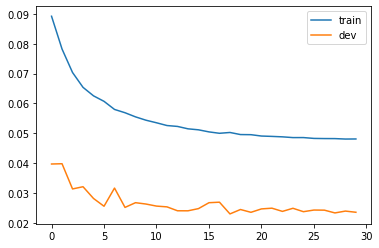

In [142]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### Test set evaluation

In [143]:
test_set.head()

,t_dat,customer_id,article_id,article_id_idx
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,78503
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,74893
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,74893
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105,24872
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001,104987


In [144]:
test_set['article_id_idx'] = test_set['article_id'].map(article_id_to_idx)

test_set['article_id_idx'].fillna(999999, inplace=True)

test_set_by_customer = test_set.groupby('customer_id').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'article_id_idx'})
test_set_by_customer.head()

,customer_id,article_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79..."


In [145]:
test_set.shape

(32995, 4)

In [146]:
train_set.head()

,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,8789,80922,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0.0,0.0,0,0,30.0,293202
1,0,1892,84641,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,1.0,1.0,0,1,21.0,83211
2,0,6818,3280,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0.0,0.0,0,0,23.0,17012
3,0,5935,51120,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,1.0,1.0,0,1,49.0,319383
4,0,6136,86781,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0.0,0.0,0,0,20.0,28596


In [147]:
test_data = test_set_by_customer.copy()[['customer_id']]
test_data['customer_id_idx'] = test_data['customer_id'].map(customer_id_to_idx)
test_data.drop(columns='customer_id', inplace=True)
test_data.head()

,customer_id_idx
0,0
1,1
2,4987
3,1071
4,6281


In [148]:
test_data['join_key'] = 1

In [149]:
top1000_items_df = pd.DataFrame({'article_id': top_1000})
top1000_items_df['article_id_idx'] = top1000_items_df['article_id'].map(article_id_to_idx)
top1000_items_df.drop(columns=['article_id'], inplace=True)
top1000_items_df['join_key'] = 1
top1000_items_df.head()

,article_id_idx,join_key
0,53892,1
1,53893,1
2,1713,1
3,24837,1
4,70221,1


In [150]:
test_data = test_data.merge(top1000_items_df, on='join_key').drop('join_key', axis=1)

test_data.head()

,customer_id_idx,article_id_idx
0,0,53892
1,0,53893
2,0,1713
3,0,24837
4,0,70221


In [151]:
test_data.shape

(9208000, 2)

In [152]:
# test_data = test_data.merge(articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], on=['article_id_idx'])

test_data = test_data.merge(
    customers.drop(columns='customer_id'),
    on='customer_id_idx'
)

print(test_data.shape)

test_data.head()

(9208000, 8)


,customer_id_idx,article_id_idx,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,53892,0.0,0.0,0,0,24.0,2
1,0,53893,0.0,0.0,0,0,24.0,2
2,0,1713,0.0,0.0,0,0,24.0,2
3,0,24837,0.0,0.0,0,0,24.0,2
4,0,70221,0.0,0.0,0,0,24.0,2


In [153]:
test_data['purchased'] = 999

In [154]:
test_dataset = PurchasesDatasetWithArticleFeatures(test_data)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*4)  

In [155]:
test_predictions = []

fashion_rec_v2.eval()

with torch.no_grad():
    for data in tqdm(test_loader):

        user_id, item_id, numeric_features, label = data
        
        user_id, item_id, numeric_features, label = (
            user_id.to(device), 
            item_id.to(device), 
            numeric_features.to(device),
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            numeric_features.float()
        )
        
        test_predictions += pred.flatten().tolist()

100%|██████████| 1125/1125 [01:01<00:00, 18.21it/s]


In [156]:
len(test_predictions)

9208000

In [157]:
len(test_dataset)

9208000

In [158]:
test_data['prediction'] = test_predictions

In [159]:
test_data.head()

,customer_id_idx,article_id_idx,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,purchased,prediction
0,0,53892,0.0,0.0,0,0,24.0,2,999,0.001374
1,0,53893,0.0,0.0,0,0,24.0,2,999,0.001374
2,0,1713,0.0,0.0,0,0,24.0,2,999,0.002692
3,0,24837,0.0,0.0,0,0,24.0,2,999,0.000238
4,0,70221,0.0,0.0,0,0,24.0,2,999,0.003513


In [160]:
test_data.sort_values(['customer_id_idx', 'prediction'], ascending=False, inplace=True)

test_data_top12 = test_data.groupby('customer_id_idx').head(12).groupby('customer_id_idx').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'predictions'})
test_data_top12.head()

,customer_id_idx,predictions
0,0,"[1469, 1477, 51505, 59458, 81746, 16853, 20850..."
1,1,"[77908, 77913, 83375, 9, 81219, 2236, 4015, 95..."
2,2,"[75925, 75912, 75922, 75923, 75921, 75920, 173..."
3,3,"[46434, 46438, 46426, 46425, 46428, 81824, 818..."
4,4,"[75, 74, 77, 9, 24266, 81219, 30732, 62461, 28..."


In [161]:
test_set_by_customer['customer_id_idx'] = test_set_by_customer['customer_id'].map(customer_id_to_idx)

test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503],0
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912...",1
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]",4987
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66...",1071
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79...",6281


In [162]:
test_set_by_customer = test_set_by_customer.merge(test_data_top12, on='customer_id_idx')
test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx,predictions
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503],0,"[1469, 1477, 51505, 59458, 81746, 16853, 20850..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912...",1,"[77908, 77913, 83375, 9, 81219, 2236, 4015, 95..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]",4987,"[9916, 16534, 58457, 73698, 86698, 17043, 1704..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66...",1071,"[67, 73, 32742, 32743, 13400, 74740, 74739, 74..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79...",6281,"[67, 2236, 2865, 73, 82790, 9, 851, 4444, 426,..."


In [163]:
predictions = test_set_by_customer['predictions'].to_list()

actuals = test_set_by_customer['article_id_idx'].to_list()

In [164]:
mapk(actuals, predictions, k=12)

0.0049386196184302645

In [165]:
test_set_by_customer['predictions'].astype(str).nunique()

8825

In [166]:
most_pop_12 = (train_set.groupby('article_id_idx')['customer_id'].count()).sort_values(ascending=False).head(12).index.to_list()
most_pop_12 = set(most_pop_12)
most_pop_12

{8, 67, 73, 75, 115, 367, 1713, 2236, 3091, 24837, 53892, 53893}

In [167]:
test_set_by_customer['num_top_12_items'] = test_set_by_customer['predictions'].apply(lambda x: len(set(x).intersection(most_pop_12)))

test_set_by_customer['num_top_12_items'].value_counts().sort_index()

0    4561
1    2512
2    1096
3     741
4     207
5      52
6      39
Name: num_top_12_items, dtype: int64